Отчет по проекту “Сделай мир чище”
Анализ рынка клининговых услуг в регионах России

Введение
Цель проекта:
Создать сервис, предоставляющий предпринимателям аналитику по рынку
клининговых услуг для оптимизации цен, выявления перспективных регионов и
оценки конкуренции.

Основные задачи:
1. Сбор данных из открытых источников (Авито, Яндекс.Услуги, Росстат).
2. Анализ цен, отзывов, надежности организаций, предоставляющие услуги.
3. Перенос всех даннных в датареймы.
4. Визуализация данных для принятия решений.

Методология
Источники данных:
1. Статический парсинг (Авито(в случае если объявлений меньше 50)).
2. Динамический парсинг (Avito, Яндекс.услуги с помощью Selenium).
Инструменты:
• Python-библиотеки: Selenium, BeautifulSoup, pandas, Plotly, Matplotlib.

Ход работы


Данные, которые сохраняются после парсинга Авито и Яндекс.услуг:

1. Название и ссылка
2. Цена
3. Надежность
4. Рейтинг
5. Зона выезда

Ниже представлен статический парсинг для главной страницы авито. Он удобен, если немного объявлений:

In [ ]:
import requests
import re
from bs4 import BeautifulSoup
from urllib.parse import urljoin, unquote
import time
import pandas as pd
import random

def parse_avito(city):
    base_url = f'https://www.avito.ru/{city}/predlozheniya_uslug/uborka_klining/generalnaya_uborka'
    results = []
    user_agents = [
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
        "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.1.1 Safari/605.1.15",
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:89.0) Gecko/20100101 Firefox/89.0",
    ]

    with requests.Session() as session:
        total_processed = 0
        current_url = base_url

        while current_url:
            try:
                user_agent = random.choice(user_agents)
                headers = {
                    'User-Agent': user_agent,
                    'Referer': base_url,
                    'Accept-Language': 'ru',
                    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
                    'Accept-Encoding': 'gzip, deflate, br',
                    'Connection': 'keep-alive',
                }

                response = session.get(current_url, headers=headers)
                response.raise_for_status()

                soup = BeautifulSoup(response.text, 'html.parser')
                items_container = soup.find('div', class_='items-items-pZX46')
                if not items_container:
                    print(f"Страница {current_url} - контейнер не найден")
                    break

                items = items_container.find_all('div', class_="iva-item-body-GQomw")

                for item in items:
                    try:
                        title_tag = item.find('h3', itemprop="name")
                        title = title_tag.text.strip() if title_tag else "Без названия"

                        price_element = item.find('p', {'data-marker': 'item-price'}).find('strong')
                        price_text = price_element.text.strip() if price_element else "Цена не указана"

                        price_match = re.search(r'(\d+(?:\s*\d+)*)', price_text)
                        if price_match:
                            price = price_match.group(0).strip()
                        else:
                            price = "Цена не найдена"

                        link = urljoin(current_url, item.find('a')['href']) if item.find('a') else None
                        link = unquote(link) if link else None

                        results.append({
                            'title': title,
                            'price': price,
                            'link': link,
                        })

                        total_processed += 1
                        print(f"Обработано объявлений: {total_processed}")
                    except Exception as e:
                        print(f"Ошибка парсинга элемента: {e}")

                next_page_tag = soup.find('a', {'data-marker': 'pagination-button/next'})
                if next_page_tag:
                    current_url = urljoin(base_url, next_page_tag['href'])
                else:
                    current_url = None
                time.sleep(6)

            except requests.exceptions.RequestException as e:
                print(f"Ошибка запроса страницы {current_url}: {e}")
                break

    return results

if __name__ == '__main__':
    city = input("Введите город (латиницей, например 'moskva'): ").strip().lower()
    data = parse_avito(city)

    if data:
        print(f"\nНайдено объявлений: {len(data)}")
        df = pd.DataFrame(data)
        df.to_csv('avito_data.csv', index=False)
        print("Данные сохранены в avito_data.csv")
        df.to_excel('avito_data.xlsx', index=False)
        print("Данные сохранены в avito_data.xlsx")
    else:
        print("Объявления не найдены")

Ниже представлен динамический парсинг для авито. Он удобен в остальных случаях:

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import time



def parse_avito(city, max_pages=3):

    base_url = f'https://www.avito.ru/{city}/predlozheniya_uslug/uborka_klining/generalnaya_uborka'
    results = []
    driver = webdriver.Chrome()
    options = webdriver.ChromeOptions()
    options.add_argument("--headless")
    options.add_argument("--disable-gpu")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")

    driver.get(base_url)
    time.sleep(3)

    for page in range(1, max_pages + 1):
        url = f"{base_url}?p={page}" if page > 1 else base_url
        driver.get(url)
        time.sleep(5)
        try:
            items = driver.find_elements(By.CLASS_NAME, "iva-item-body-GQomw")

            for item in items:
                try:
                    title_tag = item.find_element(By.TAG_NAME, "h3")
                    title = title_tag.text.strip() if title_tag else "Без названия"

                    try:
                        price_tag = item.find_element(By.CSS_SELECTOR, '[data-marker="item-price"] strong')
                        price = price_tag.text.strip()
                    except:
                        price = "Цена не указана"
                    try:
                        link_tag = item.find_element(By.TAG_NAME, "a")
                        link = link_tag.get_attribute("href")
                    except:
                        link = None

                    results.append({
                        'title': title,
                        'price': price,
                        'link': link,
                        'page': page
                    })

                except Exception as e:
                    print(f"Ошибка парсинга элемента: {e}")

            print(f"Обработана страница {page}")

        except Exception as e:
            print(f"Ошибка при загрузке страницы {page}: {e}")

    driver.quit()
    return results

if __name__ == '__main__':
    city = input("Введите город (латиницей, например 'moskva'): ").strip().lower()
    data = parse_avito(city, max_pages=3)

    if data:
        print(f"\nНайдено объявлений: {len(data)}")
        df = pd.DataFrame(data)
        df.to_csv('avito_data.csv', index=False)
        print("Данные сохранены в avito_data.csv")

    else:
        print("Объявления не найдены")


Получив датафрейм с ссылками на каждое объявление, мы можем динамически пропарсить их.

In [ ]:

driver = webdriver.Chrome()
options = webdriver.ChromeOptions()
options.add_argument("--headless")
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
df = pd.read_csv("C:\\Users\\krist\\Downloads\\avito_data (1).csv")
data_list = []

for index, row in df.iterrows():
    url = row[2]
    driver.get(url)
    time.sleep(3)

    try:
        badge = driver.find_element(By.XPATH, '//div[@data-marker="badge-title-23"]')
        if "Документы проверены" in badge.text:
            verified = "Документы проверены"
        else:
            verified = "Документы НЕ проверены"
    except:
        verified = "Документы НЕ проверены"

    try:
        geo_zone = driver.find_element(By.XPATH, '//div[@class="style-availableGeoZones-eGnre"]/span').text
    except:
        geo_zone = None

    try:
        price = driver.find_element(By.XPATH, '//div[contains(@data-marker, "PRICE_LIST_VALUE_MARKER")]/div[2]/p[1]/strong').text
    except:
        price = None

    try:
        rating_element = driver.find_element(By.XPATH, '//div[contains(@class, "styles-badge-JtDpC")]//span')
        rating = rating_element.text
    except:
        rating = None

    params = driver.find_elements(By.CLASS_NAME, 'params-paramsList__item-_2Y2O')

    experience = None
    for param in params:

        text = param.text
        if "Опыт работы" in text:
            experience = text.split(":")[1].strip()
            break

    try:
        reviews = driver.find_element(By.XPATH, '//span[contains(text(), "отзывов клиентов")]').text
    except:
        reviews = None


    data_list.append({
        "Ссылка": url,
        "Реквизиты": verified,
        "Зона доступа": geo_zone,
        "Опыт работы": experience,
        "Цена за генеральную уборку": price,
        "Рейтинг": rating,
        "Количество отзывов": reviews
    })


driver.quit()

result_df = pd.DataFrame(data_list)
result_df.to_csv("avito_detailed.csv", index=False, encoding="utf-8")

print("Парсинг завершен! Данные сохранены в 'avito_detailed.csv'.")


Динамический парсинг яндекс.услуг:

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import time

driver = webdriver.Chrome()
options = webdriver.ChromeOptions()
options.add_argument("--headless")
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
print("Введите, например:", "\n213-moscow", '\n2-saint-petersburg', '\n12-smolensk')
city = input()
url = f"https://uslugi.yandex.ru/{city}/category/hozyajstvo-i-uborka/uborka--3124?from=suggest&text=генеральная+уборка"
driver.get(url)
time.sleep(5)

def parse_page():
    results = []
    try:
        ads_container = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CLASS_NAME, "Content_inner-gap_l"))
        )
        ads = ads_container.find_elements(By.CLASS_NAME, "WorkerCard-Main")
    except Exception as e:
        print("Ошибка загрузки объявлений:", e)
        return results

    for ad in ads:
        if "реклама" in ad.text.lower():
            continue

        try:
            title_element = ad.find_element(By.CSS_SELECTOR, ".WorkerCard-Title")
            title = title_element.text
            link = title_element.get_attribute("href")
        except:
            title, link = "Не найдено", "#"

        try:
            reviews_element = ad.find_element(By.CLASS_NAME, "WorkerCard-ReviewsLink")
            reviews = reviews_element.text.split()[0]
        except:
            reviews = "Нет оценок"

        try:
            achievements = ad.find_elements(By.CLASS_NAME, "Achievement-Text")
            verification_status = ", ".join([a.text for a in achievements])
        except:
            verification_status = "Нет данных"

        try:
            price_element = ad.find_element(By.CLASS_NAME, "WorkerCard-Price")
            price = price_element.text
        except:
            price = "Цена не указана"

        results.append({
            "Название": title,
            "Ссылка": link,
            "Количество оценок": reviews,
            "Статус проверки": verification_status,
            "Цена": price
        })
    return results

all_results = []
while True:
    all_results.extend(parse_page())
    try:
        next_page = WebDriverWait(driver, 5).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, ".Pager-Item[rel='next']"))
        )
        next_page_url = next_page.get_attribute("href")
        if not next_page_url:
            break
        driver.get(next_page_url)
        time.sleep(3)
    except:
        break

df = pd.DataFrame(all_results)
df.to_csv("yandex_services.csv", index=False, encoding="utf-8")
details = []
for index, row in df.iterrows():
    driver.get(row["Ссылка"])
    time.sleep(3)

    try:
        area_element = driver.find_element(By.CLASS_NAME, "WorkerMap-Areas")
        area = area_element.text.replace("Области выезда", "").strip()
    except:
        area = "Не указано"

    try:
        rating_element = driver.find_element(By.CLASS_NAME, "Rating")
        rating = len(rating_element.find_elements(By.CLASS_NAME, "Rating-Star_filled"))
    except:
        rating = "Нет рейтинга"

    try:
        reviews_element = driver.find_element(By.CLASS_NAME, "WorkerReviews-List")
        reviews_text = reviews_element.text
    except:
        reviews_text = "Нет отзывов"
    try:
            experience_element = driver.find_element(By.XPATH, "//span[contains(text(), 'Опыт')]/../../div[contains(@class, 'KeyValue-RightCol')]//span[contains(@class, 'TextCut-Text')]")
            experience = experience_element.text
    except:
            experience = "Не указан"
    try:
            reviews_element = driver.find_element(By.CSS_SELECTOR, ".ReviewsLink-Text")
            reviews_text = reviews_element.text
            reviews = ''.join(filter(str.isdigit, reviews_text)) or "Нет оценок"
    except:
            reviews = "Нет оценок"
    details.append({
        "Название": row["Название"],
        "Ссылка": row["Ссылка"],
        "Зона выезда": area,
        "Рейтинг": rating,
        "Опыт": experience,
        "Кол-во отзыввов": reviews,
        "Отзывы": reviews_text
    })

df_details = pd.DataFrame(details)
df_details.to_csv("yandex_services_details.csv", index=False, encoding="utf-8")
driver.quit()
print("Парсинг завершен, данные сохранены в yandex_services.csv")

Дашборды и визуализация данных:

In [39]:
import pandas as pd
import plotly.express as px
df = pd.read_csv('avito_detailed_moscow_5.csv')

df['Цена за генеральную уборку'] = df['Цена за генеральную уборку'].str.replace('от ', '').str.replace(' ₽', '').str.replace(' ', '')
df['Цена за генеральную уборку'] = df['Цена за генеральную уборку'].replace('Бесплатно', '0').astype(float)
df['Рейтинг'] = df['Рейтинг'].str.replace(',', '.').astype(float)
df['Количество отзывов'] = df['Количество отзывов'].str.extract('(\d+)').astype(float)
if 'Рейтинг' in df.columns:
    fig1 = px.histogram(df, x='Рейтинг', nbins=20, title='Распределение рейтингов',
                        labels={'Рейтинг': 'Рейтинг', 'count': 'Частота'},
                        color_discrete_sequence=['#FF69B4'])
    fig1.update_layout(xaxis_title='Рейтинг', yaxis_title='Частота', showlegend=False)
    fig1.show()

if 'Количество отзывов' in df.columns and 'Рейтинг' in df.columns:
    fig2 = px.scatter(df, x='Количество отзывов', y='Рейтинг', title='Зависимость рейтинга от количества отзывов',
                      labels={'Количество отзывов': 'Количество отзывов', 'Рейтинг': 'Рейтинг'},
                      color='Опыт работы', color_discrete_sequence=['#93C572'])
    fig2.update_layout(xaxis_title='Количество отзывов', yaxis_title='Рейтинг')
    fig2.show()

if 'Цена за генеральную уборку' in df.columns and 'Опыт работы' in df.columns:
    fig3 = px.box(df, x='Опыт работы', y='Цена за генеральную уборку', title='Цена за уборку в зависимости от опыта',
                  labels={'Опыт работы': 'Опыт работы', 'Цена за генеральную уборку': 'Цена (₽)'},
                  color='Опыт работы', color_discrete_sequence=['#FFB6C1'])
    fig3.update_layout(xaxis_title='Опыт работы', yaxis_title='Цена за генеральную уборку')
    fig3.show()

if 'Цена за генеральную уборку' in df.columns and 'Рейтинг' in df.columns:
    fig4 = px.scatter(df, x='Цена за генеральную уборку', y='Рейтинг', title='Рейтинг vs Цена за генеральную уборку',
                      labels={'Цена за генеральную уборку': 'Цена (₽)', 'Рейтинг': 'Рейтинг'},
                      color='Опыт работы', color_discrete_sequence=['#FF69B4'])
    fig4.update_layout(xaxis_title='Цена за генеральную уборку', yaxis_title='Рейтинг')
    fig4.show()

гр сравнения

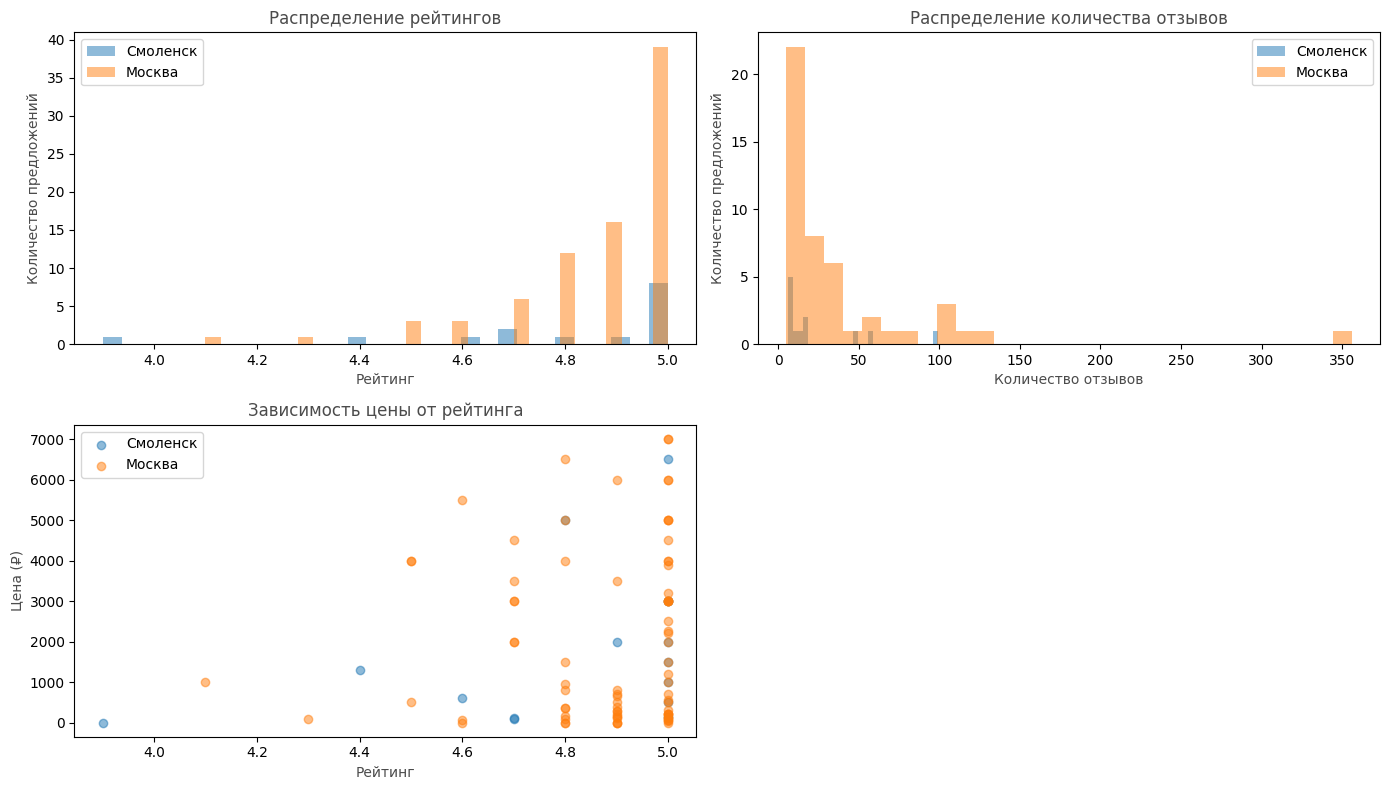

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

moscow_data = pd.read_csv('/content/avito_detailed.csv')
spb_data = pd.read_csv('/content/avito_detailed_moscow_5.csv')

def process_price(price):
    if price == 'Бесплатно':
        return 0.0
    price = price.replace('от ', '').replace(' ₽', '').replace(' ', '')
    return float(price)

moscow_data['Цена за генеральную уборку'] = moscow_data['Цена за генеральную уборку'].apply(process_price)
spb_data['Цена за генеральную уборку'] = spb_data['Цена за генеральную уборку'].apply(process_price)

moscow_data['Рейтинг'] = moscow_data['Рейтинг'].str.replace(',', '.').astype(float)
spb_data['Рейтинг'] = spb_data['Рейтинг'].str.replace(',', '.').astype(float)

moscow_data['Количество отзывов'] = moscow_data['Количество отзывов'].str.extract('(\d+)').astype(float)
spb_data['Количество отзывов'] = spb_data['Количество отзывов'].str.extract('(\d+)').astype(float)

plt.figure(figsize=(14, 8))


plt.subplot(2, 2, 1)
plt.hist(moscow_data['Рейтинг'], bins=30, alpha=0.5, label='Смоленск')
plt.hist(spb_data['Рейтинг'], bins=30, alpha=0.5, label='Москва')
plt.title('Распределение рейтингов')
plt.xlabel('Рейтинг')
plt.ylabel('Количество предложений')
plt.legend()

plt.subplot(2, 2, 2)
plt.hist(moscow_data['Количество отзывов'], bins=30, alpha=0.5, label='Смоленск')
plt.hist(spb_data['Количество отзывов'], bins=30, alpha=0.5, label='Москва')
plt.title('Распределение количества отзывов')
plt.xlabel('Количество отзывов')
plt.ylabel('Количество предложений')
plt.legend()

plt.subplot(2, 2, 3)
plt.scatter(moscow_data['Рейтинг'], moscow_data['Цена за генеральную уборку'], alpha=0.5, label='Смоленск')
plt.scatter(spb_data['Рейтинг'], spb_data['Цена за генеральную уборку'], alpha=0.5, label='Москва')
plt.title('Зависимость цены от рейтинга')
plt.xlabel('Рейтинг')
plt.ylabel('Цена (₽)')
plt.legend()

plt.tight_layout()
plt.show()